# Multi-Class Classification

## 1. Imports

In [1]:
import ast
import random
from collections import Counter
from pathlib import Path

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
from wordcloud import WordCloud

from preprocess_functions import build_tree, extract_keys, preprocess_texts, map_targets
from utils import CalibratedLabelRankClassifier, ChainOfClassifiers, LabelPowersetClassifier, \
    assess_models, prune_and_subsample, ConditionalDependencyNetwork, MetaBinaryRelevance

## 2. Configurations & Constants

### Global Configuration Constants

In [2]:
OVERWRITE = True
RETRAIN = True
RANDOM_STATE = 42
MODEL_LEVEL = 'general'

### Set Random Seeds

In [3]:
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

### Testing Parameters

In [4]:
TEST_SIZE = 2e-1

### Category Mappings

In [5]:
FIX_TARGETS = {
    'computer security': 'computer security',
    'operating systems': 'operating systems',
    'software': 'software',
    'programming languages': 'software',
    'hardware': 'hardware',
    'electronic components': 'hardware',
    'networking': 'networking',
    'internet technology': 'networking'
}

### Base Models

In [6]:
BASE_CLASSIFIERS = {
    'logistic_regression': LogisticRegression(solver='liblinear', random_state=RANDOM_STATE, class_weight='balanced'),
    'gaussian_nb': GaussianNB(),
    'decision_tree': DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
    'random_forest': RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
    'xgb': xgb.XGBClassifier(random_state=RANDOM_STATE),
}

### Directory Paths

In [7]:
COLAB_DIR = Path('/content/drive/MyDrive')
KAGGLE_DIR = Path('/kaggle/input')
LOCAL_DIR = Path('./')

try:
    import google.colab

    IN_COLAB = True
except ImportError:
    IN_COLAB = False

try:
    import kaggle_secrets

    IN_KAGGLE = True
except ImportError:
    IN_KAGGLE = False

if IN_COLAB:
    DATA_DIR = COLAB_DIR / 'data'
    MODELS_DIR = COLAB_DIR / 'models'
elif IN_KAGGLE:
    DATA_DIR = KAGGLE_DIR
    MODELS_DIR = KAGGLE_DIR
else:
    DATA_DIR = LOCAL_DIR / 'data'
    MODELS_DIR = LOCAL_DIR / 'models'

### Dataset & Model Paths

In [8]:
BINARY_PROBLEMS_DIR = MODELS_DIR / 'binary_problems'
ENSEMBLES_DIR = MODELS_DIR / 'ensembles'
MULTICLASS_PROBLEMS_DIR = MODELS_DIR / 'multiclass_problems'
GLOVE_DIR = MODELS_DIR / 'glove-embeddings'
GLOVE_6B_300D_TXT = GLOVE_DIR / 'glove.6B.300d.txt'

DATASET_DIR = DATA_DIR / 'tweets-dataset-for-cyberattack-detection'
THREAT_TWEETS_CSV = DATASET_DIR / 'tweets_train.csv'

BR_PKL = BINARY_PROBLEMS_DIR / f'br_{MODEL_LEVEL}.pkl'
CLR_PKL = BINARY_PROBLEMS_DIR / f'clr_{MODEL_LEVEL}.pkl'
CC_PKL = BINARY_PROBLEMS_DIR / f'cc_{MODEL_LEVEL}.pkl'

LP_PKL = MULTICLASS_PROBLEMS_DIR / f'lp_{MODEL_LEVEL}.pkl'
PST_PKL = MULTICLASS_PROBLEMS_DIR / f'pst_{MODEL_LEVEL}.pkl'

CDN_PKL = ENSEMBLES_DIR / f'pkl_{MODEL_LEVEL}.pkl'
MBR_PKL = ENSEMBLES_DIR / f'mbr_{MODEL_LEVEL}.pkl'

### Loading Models

In [9]:
br = joblib.load(filename=BR_PKL) if BR_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
clr = joblib.load(filename=CLR_PKL) if CLR_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
cc = joblib.load(filename=CC_PKL) if CC_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
lp = joblib.load(filename=LP_PKL) if LP_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
pst = joblib.load(filename=PST_PKL) if PST_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
cdn = joblib.load(filename=CDN_PKL) if CDN_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
mbr = joblib.load(filename=MBR_PKL) if MBR_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)

## 3. Data Loading & Preprocessing

Load the dataset, inspect its structure, and preprocess it for machine learning models.
For the goal of the project, the categories of interest are:
1. computer security/network security
2. computer security/antivirus and malware
3. operating systems/mac os
4. operating systems/windows
5. operating systems/unix
6. operating systems/linux
7. software
8. programming languages, included in software
9. software/databases
10. hardware
11. electronic components, included in hardware
12. hardware/computer/servers
13. hardware/computer/portable computer
14. hardware/computer/desktop computer
15. hardware/computer components
16. hardware/computer networking/router
17. hardware/computer networking/wireless technology
18. networking
19. internet technology, included in networking

In [10]:
threat_tweets = (
    pd.read_csv(filepath_or_buffer=THREAT_TWEETS_CSV)
    .assign(
        tweet=lambda df: df['tweet'].apply(func=ast.literal_eval),
        watson=lambda df: df['watson'].apply(func=ast.literal_eval)
        .apply(func=lambda x: x.get('categories', []))
        .apply(func=build_tree),
        watson_list=lambda df: df['watson'].apply(func=extract_keys),
        target=lambda df: df['watson_list'].apply(func=map_targets, args=(FIX_TARGETS,))
    )
    .query(expr='relevant == True')
    .drop(labels=[
        'relevant', '_id', 'date',
        'id', 'tweet', 'type',
        'annotation', 'urls', 'destination_url',
        'valid_certificate'
    ], axis=1)
    .dropna(subset=['text'], ignore_index=True)
)

print(f"Threat Tweets: {len(threat_tweets)}")
threat_tweets.head()

Threat Tweets: 8889


,text,watson,watson_list,target
0,Protonmail DDoS Attacks: British Bomb Threat T...,{'technology and computing': {'computer securi...,"[technology and computing, computer security, ...",[computer security]
1,"@elonmusk As I see it, @Tesla needs to hire mo...",{'automotive and vehicles': {'electric vehicle...,"[automotive and vehicles, electric vehicles, c...",[other]
2,Watched GoT for the first #shellshock vulnerab...,"{'society': {'unrest and war': {}}, 'technolog...","[society, unrest and war, technology and compu...",[computer security]
3,U.K. Teen Involved in ProtonMail DDoS Attack A...,{'technology and computing': {'computer securi...,"[technology and computing, computer security, ...",[computer security]
4,.@CenturyLink Francis Prince Thangasamy shares...,{'technology and computing': {'computer securi...,"[technology and computing, computer security, ...",[computer security]


## 4. Exploratory Data Analysis (EDA)
Here are uncovered patterns, relationships, and potential issues in the data that could impact model performances.

### 4.1. Text Analysis
The `text` attribute is examined using word frequency analysis, word clouds, and text length distribution.
It helps in identifying common words, potential stopwords, and variations in text length that may impact feature engineering.

#### 4.1.1. Word Frequency

In [11]:
all_words = ' '.join(threat_tweets['text']).split()
word_freq = Counter(all_words)
print("Top 10 Most Frequent Words:", word_freq.most_common(10))

Top 10 Most Frequent Words: [('the', 2156), ('a', 1888), ('in', 1876), ('to', 1831), ('of', 1733), ('-', 1651), ('and', 1354), ('vulnerability', 1254), ('Vulnerability', 1140), ('is', 876)]


#### 4.1.2. Word Cloud

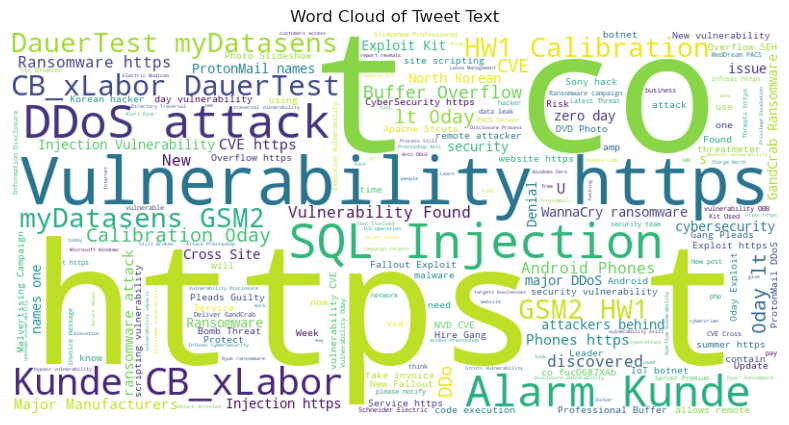

In [12]:
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate(text=' '.join(threat_tweets['text']))

plt.figure(figsize=(15, 5))
plt.imshow(X=wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweet Text')
plt.show()

#### 4.1.3. Text Length Distribution

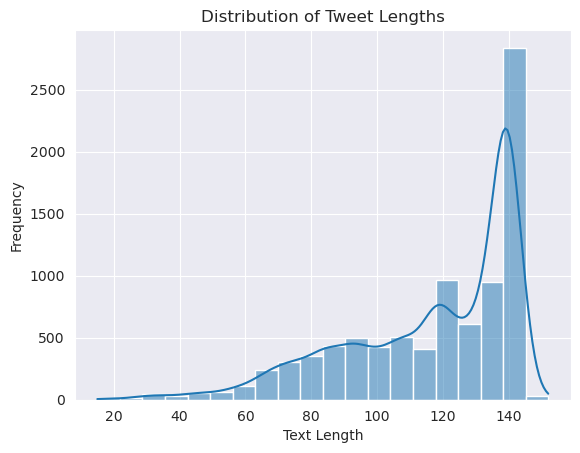

In [13]:
threat_tweets['text_length'] = threat_tweets['text'].apply(func=len)
sns.histplot(
    data=threat_tweets['text_length'],
    bins=20,
    kde=True
)
plt.title(label='Distribution of Tweet Lengths')
plt.xlabel(xlabel='Text Length')
plt.ylabel(ylabel='Frequency')
plt.show()

### 4.3. Watson List Analysis
In the `watson_list` attribute, it is performed category depth, co-occurrence patterns, and top-level category distribution analyses.

In [14]:
# Flatten watson_list and count category frequencies
all_categories = [category for sublist in threat_tweets['watson_list'] for category in sublist]
category_freq = Counter(all_categories)
print("Top 10 Most Frequent Categories:", category_freq.most_common(n=10))

Top 10 Most Frequent Categories: [('technology and computing', 8057), ('computer security', 4653), ('antivirus and malware', 3412), ('software', 2941), ('hardware', 1741), ('network security', 1698), ('society', 1626), ('computer', 1375), ('crime', 1271), ('business and industrial', 1225)]


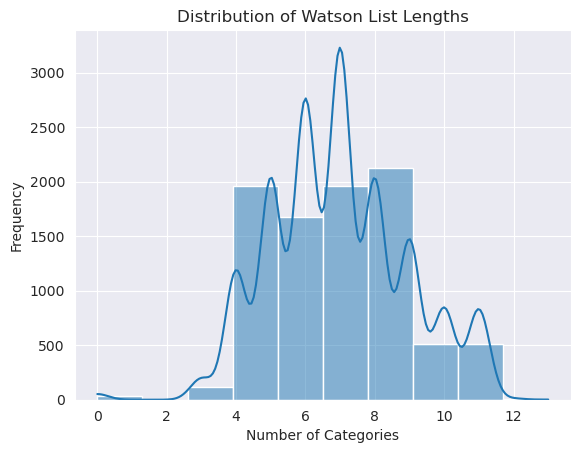

In [15]:
# Category Depth Analysis
threat_tweets['watson_list_length'] = threat_tweets['watson_list'].apply(func=len)

sns.histplot(
    data=threat_tweets['watson_list_length'],
    bins=10,
    kde=True
)

plt.title(label='Distribution of Watson List Lengths')
plt.xlabel(xlabel='Number of Categories')
plt.ylabel(ylabel='Frequency')
plt.show()

In [16]:
# Create co-occurrence matrix
co_occurrence = Counter()
for categories in threat_tweets['watson_list']:
    for i in range(len(categories)):
        for j in range(i + 1, len(categories)):
            co_occurrence[(categories[i], categories[j])] += 1

print("Top 10 Co-occurring Category Pairs:", co_occurrence.most_common(n=10))

Top 10 Co-occurring Category Pairs: [(('technology and computing', 'computer security'), 4653), (('technology and computing', 'antivirus and malware'), 3412), (('computer security', 'antivirus and malware'), 3412), (('technology and computing', 'software'), 2941), (('technology and computing', 'hardware'), 1741), (('technology and computing', 'network security'), 1698), (('computer security', 'network security'), 1698), (('technology and computing', 'computer'), 1375), (('hardware', 'computer'), 1375), (('society', 'crime'), 1271)]


In [17]:
# Top-Level Category Distribution
top_level_categories = [category.split()[0] for category in all_categories]
top_level_freq = Counter(top_level_categories)
print("Top-Level Category Frequencies:", top_level_freq.most_common())

Top-Level Category Frequencies: [('technology', 8057), ('computer', 6849), ('antivirus', 3412), ('software', 2942), ('network', 1765), ('hardware', 1741), ('society', 1626), ('business', 1391), ('crime', 1271), ('databases', 1188), ('consumer', 1140), ('law,', 1028), ('science', 938), ('operating', 839), ('art', 824), ('home', 803), ('programming', 735), ('personal', 726), ('property', 685), ('health', 639), ('tv', 461), ('hobbies', 453), ('javascript', 423), ('networking', 414), ('government', 402), ('physics', 395), ('linux', 392), ('telephones', 383), ('optics', 381), ('burglary', 380), ('mobile', 378), ('vpn', 365), ('smart', 353), ('internet', 353), ('movies', 345), ('assault', 342), ('finance', 339), ('legal', 314), ('sports', 286), ('food', 267), ('law', 264), ('disease', 255), ('java', 243), ('travel', 243), ('company', 229), ('kidnapping', 228), ('windows', 228), ('police', 222), ('legislation', 220), ('disorders', 214), ('router', 210), ('weather', 202), ('meteorological', 19

### 4.4. Target Analysis

Target Frequencies:
software: 2851
computer security: 2746
other: 1783
networking: 684
hardware: 492
operating systems: 333


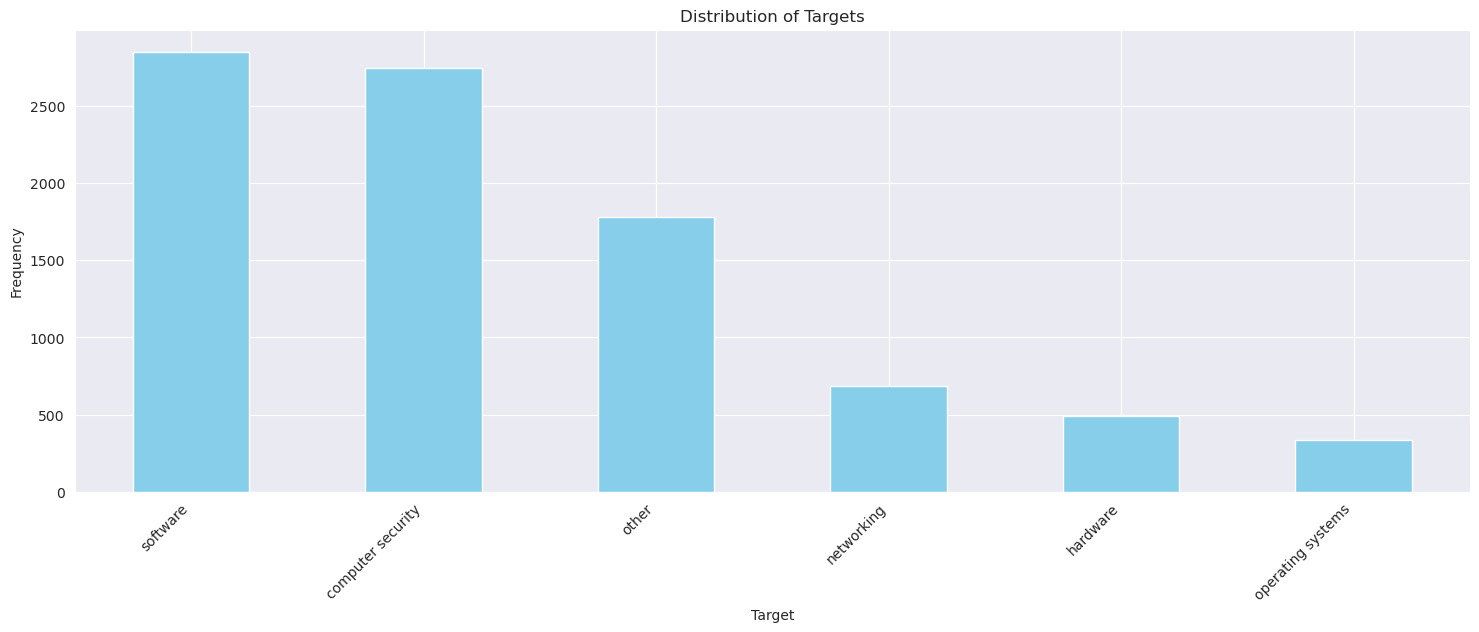

In [18]:
class_freq = Counter([item[0] for item in threat_tweets['target']])

print("Target Frequencies:")
for target, freq in class_freq.most_common():
    print(f"{target}: {freq}")

_, ax = plt.subplots(figsize=(18, 6))
pd.Series(data=class_freq).sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Distribution of Targets')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

Target Frequencies:
('computer security',): 2257
('other',): 1783
('software', 'computer security'): 1144
('software',): 644
('hardware',): 492
('computer security', 'hardware'): 435
('software', 'hardware'): 354
('software', 'operating systems'): 285
('software', 'computer security', 'hardware'): 220
('networking',): 174
('networking', 'software'): 149
('software', 'computer security', 'operating systems'): 145
('operating systems',): 119
('networking', 'computer security'): 117
('operating systems', 'computer security'): 106
('networking', 'software', 'computer security'): 83
('networking', 'hardware'): 59
('software', 'hardware', 'operating systems'): 59
('computer security', 'networking', 'software'): 54
('networking', 'computer security', 'hardware'): 54
('operating systems', 'hardware'): 53
('networking', 'software', 'hardware'): 31
('operating systems', 'computer security', 'hardware'): 30
('operating systems', 'software'): 24
('networking', 'software', 'operating systems'): 7
(

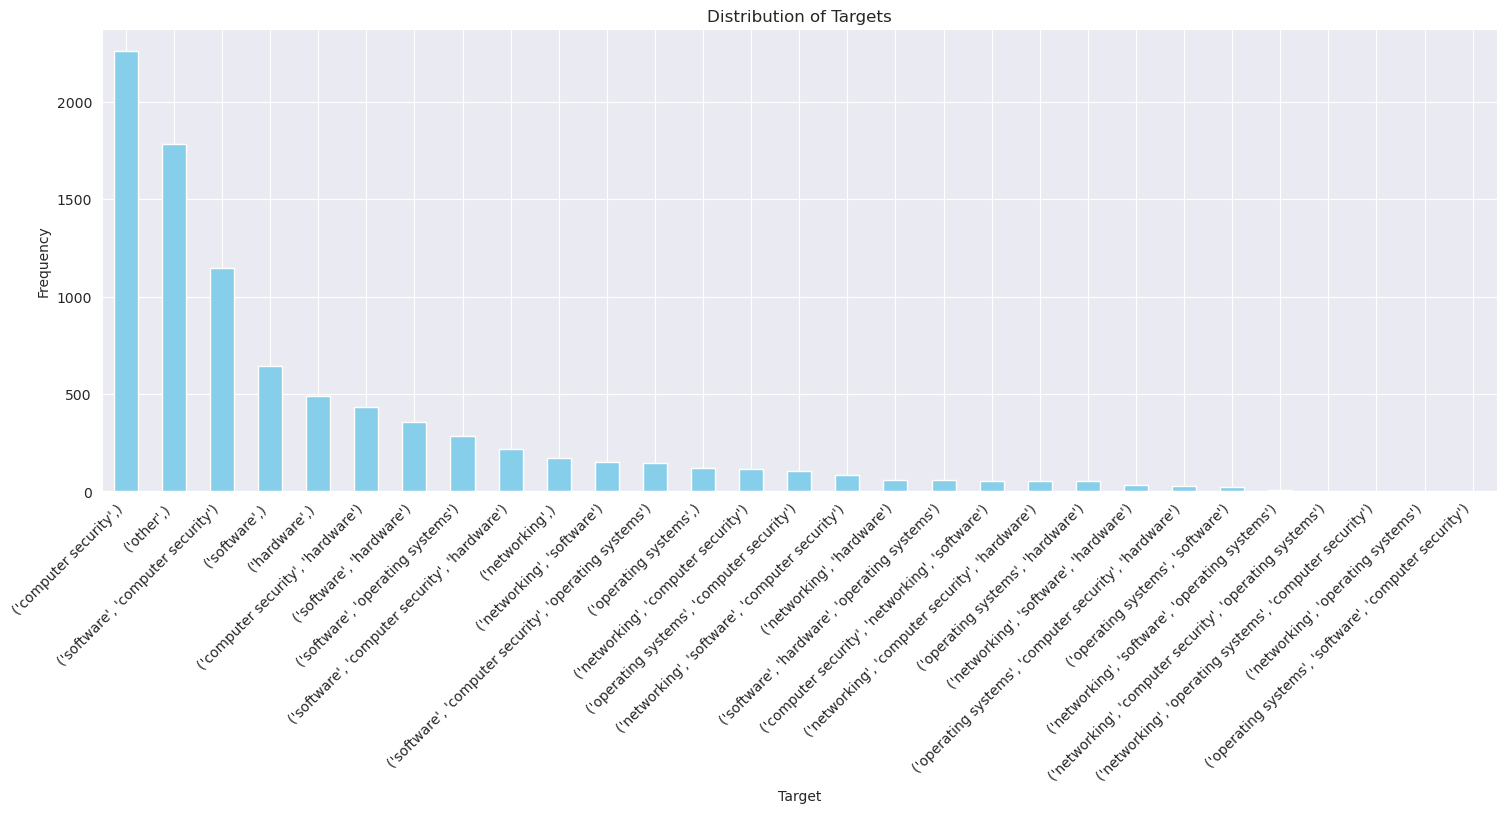

In [19]:
target_freq = Counter(tuple(item) for item in threat_tweets['target'])

print("Target Frequencies:")
for target, freq in target_freq.most_common():
    print(f"{target}: {freq}")

_, ax = plt.subplots(figsize=(18, 6))

(pd.Series(data={str(k): v for k, v in target_freq.items()})
 .sort_values(ascending=False)
 .plot(kind='bar', color='skyblue'))

plt.title('Distribution of Targets')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

In [20]:
# Multi-Label Analysis
multi_label_counts = threat_tweets['target'].apply(func=lambda x: len(x) > 1).sum()
print(f"Number of tweets with multiple targets: {multi_label_counts}")

Number of tweets with multiple targets: 3420


In [21]:
# Text-Target Relationship
target_text_pairs = [
    (target, text)
    for targets, text in zip(threat_tweets['target'], threat_tweets['text'])
    for target in targets
]

target_text_df = pd.DataFrame(data=target_text_pairs, columns=['target', 'text'])

for target in class_freq:
    target_texts = target_text_df[target_text_df['target'].apply(func=lambda x: target in x)]['text']
    vectorizer = CountVectorizer(stop_words='english')
    word_counts = vectorizer.fit_transform(raw_documents=target_texts)
    word_freq = pd.Series(data=word_counts.sum(axis=0).A1, index=vectorizer.get_feature_names_out())
    print(f"Top 10 words for target '{target}':")
    print(word_freq.nlargest(10))

Top 10 words for target 'computer security':
https            4805
vulnerability    1841
ddos             1084
ransomware        671
security          595
cve               459
2018              440
injection         435
sql               413
exploit           406
dtype: int64
Top 10 words for target 'other':
https          1536
0day            782
ransomware      612
2018            486
00              415
lt              383
alarm           377
calibration     377
cb_xlabor       377
dauertest       377
dtype: int64
Top 10 words for target 'software':
https            3488
vulnerability    1525
cve               765
2018              707
injection         485
sql               455
security          368
exploit           290
overflow          285
buffer            281
dtype: int64
Top 10 words for target 'networking':
https            832
2018             249
cve              239
vulnerability    219
remote           128
ddos              92
prestashop        86
allows            78
a

## 5. Feature Engineering

In [22]:
# Find valid targets (with frequency ≥ 5)
valid_targets = {target for target, freq in target_freq.items() if freq >= 5}

# Filter the DataFrame to keep only valid targets
filtered_df = threat_tweets[threat_tweets['target'].apply(lambda x: tuple(x) in valid_targets)]

# Reset the index (optional)
filtered_df = filtered_df.reset_index(drop=True)

# Print the updated target frequencies
updated_target_freq = Counter(tuple(item) for item in filtered_df['target'])
print("Updated Target Frequencies:")
for target, freq in updated_target_freq.most_common():
    print(f"{target}: {freq}")

Updated Target Frequencies:
('computer security',): 2257
('other',): 1783
('software', 'computer security'): 1144
('software',): 644
('hardware',): 492
('computer security', 'hardware'): 435
('software', 'hardware'): 354
('software', 'operating systems'): 285
('software', 'computer security', 'hardware'): 220
('networking',): 174
('networking', 'software'): 149
('software', 'computer security', 'operating systems'): 145
('operating systems',): 119
('networking', 'computer security'): 117
('operating systems', 'computer security'): 106
('networking', 'software', 'computer security'): 83
('networking', 'hardware'): 59
('software', 'hardware', 'operating systems'): 59
('computer security', 'networking', 'software'): 54
('networking', 'computer security', 'hardware'): 54
('operating systems', 'hardware'): 53
('networking', 'software', 'hardware'): 31
('operating systems', 'computer security', 'hardware'): 30
('operating systems', 'software'): 24
('networking', 'software', 'operating system

Preprocess the `text` column into embeddings

In [23]:
X = preprocess_texts(
    list_str=filtered_df['text'],
    model_path=GLOVE_6B_300D_TXT,
    embedding_dim=300
)

Convert the `target` column into a binary multi-label matrix

In [24]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y=filtered_df['target'])

Create a dictionary that maps label indices to unique label sets

In [25]:
unique_label_sets, y_lp = np.unique(ar=y, axis=0, return_inverse=True)
label_map_lp = {i: tuple(lbl_set) for i, lbl_set in enumerate(unique_label_sets)}

Perform pruning and subsampling of the dataset to remove infrequent targets

In [26]:
X_pst, y_pst, label_map_pst, _ = prune_and_subsample(
    x=X,
    y=y,
    pruning_threshold=np.median(np.array(list(target_freq.values()))) * .25,
    max_sub_samples=round(np.median(np.array(list(target_freq.values()))) * .25)
)

In [27]:
smote = SMOTE(random_state=42)
X, y_lp = smote.fit_resample(X, y_lp)
y = np.array(unique_label_sets[y_lp])
print(f"{X.shape}, {len(y_lp)}")

(51911, 300), 51911


## 6. Model Training

In [28]:
# BR, CLR, CC, CDN, MBR, LP
X_train, X_val, y_train, y_val, y_train_lp, y_val_lp = train_test_split(
    X, y, y_lp,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=y_lp
)

print(f"{'Training:':<15}\tX = {str(X_train.shape[0]) + ' × ' + str(X_train.shape[1]):<15}\ty = {str(y_train.shape[0]) + ' × ' + str(y_train.shape[1]):<15}")
print(f"{'Validation:':<15}\tX = {str(X_val.shape[0]) + ' × ' + str(X_val.shape[1]):<15}\ty = {str(y_val.shape[0]) + ' × ' + str(y_val.shape[1]):<15}")

Training:      	X = 41528 × 300    	y = 41528 × 6      
Validation:    	X = 10383 × 300    	y = 10383 × 6      


In [29]:
# PSt
X_train_pst, X_val_pst, y_train_pst, y_val_pst = train_test_split(
    X_pst, y_pst,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=y_pst
)
print(
    f"{'Training:':<15}\tX = {str(X_train_pst.shape[0]) + ' × ' + str(X_train_pst.shape[1]):<15}\ty = {str(len(y_train_pst)):<15}")
print(
    f"{'Validation:':<15}\tX = {str(X_val_pst.shape[0]) + ' × ' + str(X_val_pst.shape[1]):<15}\ty = {str((len(y_val_pst))):<15}")

Training:      	X = 7242 × 300     	y = 7242           
Validation:    	X = 1811 × 300     	y = 1811           


### 4.1. Binary Problems


#### 4.1.1. BR (Binary Relevance)


In [30]:
if RETRAIN:
    for k in tqdm(BASE_CLASSIFIERS.keys()):
        br[k] = OneVsRestClassifier(estimator=BASE_CLASSIFIERS[k]).fit(X=X_train, y=y_train)

100%|██████████| 5/5 [13:57<00:00, 167.50s/it]


#### 4.1.2. CLR (Calibrated Label Ranking)


In [31]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = CalibratedLabelRankClassifier(
            classifier=v,
            classes=mlb.classes_,
            random_state=RANDOM_STATE
        )

        clr[k] = model.fit(
            x=X_train,
            y=[list(mlb.classes_[np.where(row == 1)[0]]) for row in y_train]
        )

100%|██████████| 5/5 [33:15<00:00, 399.16s/it]


#### 4.1.3. CC (Classifier Chains)


In [32]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = ChainOfClassifiers(
            classifier=v,
            classes=mlb.classes_,
            random_state=RANDOM_STATE
        )

        cc[k] = model.fit(
            x=X_train,
            y=y_train
        )

100%|██████████| 5/5 [15:38<00:00, 187.73s/it]


### 4.2. Multi-class Problems



#### 4.2.1. LP (Label Powerset)


In [33]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = LabelPowersetClassifier(
            classifier=v,
            label_map=label_map_lp,
            random_state=RANDOM_STATE
        )

        lp[k] = model.fit(
            x=X_train,
            y=y_train_lp
        )

100%|██████████| 5/5 [14:48<00:00, 177.78s/it]


#### 4.2.2. PSt (Pruned Sets)


In [34]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = LabelPowersetClassifier(
            classifier=v,
            label_map=label_map_pst,
            random_state=RANDOM_STATE
        )

        pst[k] = model.fit(
            x=X_train_pst,
            y=y_train_pst
        )

100%|██████████| 5/5 [02:04<00:00, 24.86s/it]


### 4.3. Ensembles


#### 4.3.1. CDN (Conditional Dependency Network)


In [35]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = ConditionalDependencyNetwork(
            classifier=v,
            num_iterations=100,
            burn_in=10
        )

        cdn[k] = model.fit(
            x=X_train,
            y=y_train
        )

100%|██████████| 5/5 [13:02<00:00, 156.50s/it]


#### 4.3.2. MBR (Meta-Binary Relevance)


In [36]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = MetaBinaryRelevance(
            classifier=v,
            use_cross_val=True,
            n_splits=5
        )

        mbr[k] = model.fit(
            x=X_train,
            y=y_train
        )

100%|██████████| 5/5 [1:24:27<00:00, 1013.51s/it]


## 7. Model Evaluation

In [37]:
performances = {}

### 7.1. Binary Problems



#### 7.1.1. BR (Binary Relevance)


In [38]:
performances['BR'] = assess_models(
    x=X_val,
    y=y_val,
    technique=br,
    classes=mlb.classes_
)

In [39]:
y_val_hat = performances['BR']['Model'].predict(X_val)
print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                   precision    recall  f1-score   support

computer security       0.99      0.97      0.98      4516
         hardware       0.99      0.98      0.98      4515
       networking       0.99      0.99      0.99      3612
operating systems       1.00      1.00      1.00      3612
            other       0.96      0.68      0.79       451
         software       0.98      0.98      0.98      4966

        micro avg       0.99      0.98      0.98     21672
        macro avg       0.98      0.93      0.96     21672
     weighted avg       0.99      0.98      0.98     21672
      samples avg       0.96      0.96      0.96     21672

Accuracy:	0.9467
AUC:	0.9637


#### 7.1.2. CLR (Calibrated Label Ranking)


In [40]:
performances['CLR'] = assess_models(
    x=X_val,
    y=y_val,
    technique=clr,
    classes=mlb.classes_
)

In [41]:
y_val_hat = performances['CLR']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                   precision    recall  f1-score   support

computer security       0.98      0.98      0.98      4516
         hardware       0.99      0.99      0.99      4515
       networking       0.99      1.00      0.99      3612
operating systems       1.00      1.00      1.00      3612
            other       0.88      0.77      0.82       451
         software       0.99      0.98      0.98      4966

        micro avg       0.99      0.98      0.98     21672
        macro avg       0.97      0.95      0.96     21672
     weighted avg       0.99      0.98      0.98     21672
      samples avg       0.97      0.97      0.97     21672

Accuracy:	0.9496
AUC:	0.9713


#### 7.1.3. CC (Classifier Chains)


In [42]:
performances['CC'] = assess_models(
    x=X_val,
    y=y_val,
    technique=cc,
    classes=mlb.classes_
)

In [43]:
y_val_hat = performances['CC']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                   precision    recall  f1-score   support

computer security       0.98      0.98      0.98      4516
         hardware       0.98      0.99      0.99      4515
       networking       0.99      1.00      0.99      3612
operating systems       0.99      1.00      1.00      3612
            other       0.85      0.84      0.84       451
         software       0.98      0.99      0.99      4966

        micro avg       0.98      0.99      0.98     21672
        macro avg       0.96      0.96      0.96     21672
     weighted avg       0.98      0.99      0.98     21672
      samples avg       0.97      0.98      0.97     21672

Accuracy:	0.9603
AUC:	0.9772


### 7.2. Multi-class Problems




#### 7.2.1. LP (Label Powerset)



In [44]:
performances['LP'] = assess_models(
    x=X_val,
    y=np.array([list(label_map_lp[yp]) for yp in y_val_lp]),
    technique=lp,
    classes=mlb.classes_
)

In [45]:
y_val_hat = performances['LP']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                   precision    recall  f1-score   support

computer security       0.98      0.98      0.98      4516
         hardware       0.99      0.99      0.99      4515
       networking       0.99      1.00      1.00      3612
operating systems       1.00      1.00      1.00      3612
            other       0.83      0.83      0.83       451
         software       0.99      0.99      0.99      4966

        micro avg       0.99      0.99      0.99     21672
        macro avg       0.96      0.97      0.96     21672
     weighted avg       0.99      0.99      0.99     21672
      samples avg       0.98      0.98      0.98     21672

Accuracy:	0.9706
AUC:	0.9790


#### 7.2.2. PSt (Pruned Sets)


In [46]:
performances['PST'] = assess_models(
    x=X_val_pst,
    y=np.array([list(label_map_pst[yp]) for yp in y_val_pst]),
    technique=pst,
    classes=mlb.classes_
)

In [47]:
y_val_hat = performances['PST']['Model'].predict(X_val_pst)

print(classification_report(
    y_true=np.array([list(label_map_pst[yp]) for yp in y_val_pst]),
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(
    f"Accuracy:\t{accuracy_score(y_true=np.array([list(label_map_pst[yp]) for yp in y_val_pst]), y_pred=y_val_hat):.4f}")
try:
    print(
        f"AUC:\t{roc_auc_score(y_true=np.array([list(label_map_pst[yp]) for yp in y_val_pst]), y_score=y_val_hat):.4f}")
except ValueError:
    print(f"AUC:\tNot defined")

                   precision    recall  f1-score   support

computer security       0.85      0.89      0.87       929
         hardware       0.87      0.56      0.68       358
       networking       0.79      0.62      0.70       160
operating systems       0.93      0.62      0.74       179
            other       0.70      0.80      0.75       357
         software       0.87      0.76      0.81       652

        micro avg       0.83      0.77      0.80      2635
        macro avg       0.84      0.71      0.76      2635
     weighted avg       0.84      0.77      0.79      2635
      samples avg       0.81      0.78      0.78      2635

Accuracy:	0.6902
AUC:	0.8247


### 7.3. Ensembles


#### 7.3.1. CDN (Conditional Dependency Network)


In [48]:
performances['CDN'] = assess_models(
    x=X_val,
    y=y_val,
    technique=cdn,
    classes=mlb.classes_
)

In [49]:
y_val_hat = performances['CDN']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                   precision    recall  f1-score   support

computer security       0.96      0.95      0.96      4516
         hardware       0.96      0.95      0.96      4515
       networking       0.98      0.97      0.97      3612
operating systems       0.99      0.99      0.99      3612
            other       0.42      0.65      0.51       451
         software       0.97      0.95      0.96      4966

        micro avg       0.95      0.95      0.95     21672
        macro avg       0.88      0.91      0.89     21672
     weighted avg       0.96      0.95      0.96     21672
      samples avg       0.92      0.92      0.92     21672

Accuracy:	0.8897
AUC:	0.9427


#### 7.3.2. MBR (Meta-Binary Relevance)


In [50]:
performances['MBR'] = assess_models(
    x=X_val,
    y=y_val,
    technique=mbr,
    classes=mlb.classes_
)

In [51]:
y_val_hat = performances['MBR']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                   precision    recall  f1-score   support

computer security       0.99      0.98      0.98      4516
         hardware       0.99      0.99      0.99      4515
       networking       1.00      1.00      1.00      3612
operating systems       1.00      1.00      1.00      3612
            other       0.89      0.82      0.86       451
         software       0.98      0.99      0.99      4966

        micro avg       0.99      0.99      0.99     21672
        macro avg       0.97      0.96      0.97     21672
     weighted avg       0.99      0.99      0.99     21672
      samples avg       0.97      0.98      0.97     21672

Accuracy:	0.9615
AUC:	0.9778


## 8. Summary


In [52]:
performances = pd.DataFrame(performances).T
performances

,Accuracy,Classifier,Model,Precision example-based,Recall example-based,F1 example-based,Hamming loss,Micro precision,Micro recall,Micro F1,Macro precision,Macro recall,Macro F1,Coverage,Classification
BR,0.94674,xgb,OneVsRestClassifier(estimator=XGBClassifier(ba...,0.963859,0.964557,0.962521,0.011445,0.987941,0.979051,0.983476,0.984082,0.934677,0.955297,2.29269,precision recall f1-sco...
CLR,0.949629,xgb,CalibratedLabelRankClassifier(classes=array(['...,0.967399,0.969774,0.966787,0.011156,0.986186,0.981681,0.983929,0.970667,0.950469,0.959916,2.26842,precision recall f1-sco...
CC,0.96032,xgb,ChainOfClassifiers(classes=array(['computer se...,0.973402,0.976227,0.973493,0.010819,0.983068,0.98588,0.984472,0.963352,0.964069,0.963699,2.228836,precision recall f1-sco...
LP,0.970625,random_forest,LabelPowersetClassifier(classifier=RandomFores...,0.977768,0.979726,0.977913,0.008941,0.985871,0.988464,0.987166,0.96337,0.965866,0.964614,2.201194,precision recall f1-sco...
PST,0.690226,xgb,LabelPowersetClassifier(classifier=XGBClassifi...,0.812074,0.775262,0.782441,0.094239,0.831073,0.767362,0.797948,0.836013,0.70951,0.758955,2.710657,precision recall f1-sco...
CDN,0.889242,xgb,ConditionalDependencyNetwork(classifier=XGBCla...,0.924211,0.925038,0.921789,0.03204,0.953448,0.954504,0.953975,0.882559,0.917693,0.894892,2.517192,precision recall f1-sco...
MBR,0.961475,xgb,MetaBinaryRelevance(classifier=XGBClassifier(b...,0.974622,0.976323,0.974128,0.008989,0.988252,0.98588,0.987065,0.974362,0.962386,0.968151,2.22768,precision recall f1-sco...


In [53]:
if OVERWRITE:
    joblib.dump(br, BR_PKL, compress=9)
    joblib.dump(clr, CLR_PKL, compress=9)
    joblib.dump(cc, CC_PKL, compress=9)
    joblib.dump(lp, LP_PKL, compress=9)
    joblib.dump(pst, PST_PKL, compress=9)
    joblib.dump(cdn, CDN_PKL, compress=9)
    joblib.dump(mbr, MBR_PKL, compress=9)